
# WiDS Datathon Challenge 1 
### by Betty Hagos
### last updated February 3, 2024


# The Objective: 
## The task is to assess whether the likelihood of the patient’s Diagnosis Period being less than 90 days is predictable using these characteristics and information about the patient. Ultimately, we want to uncover any issues of equity in metastatic breast cancer diagnosis.

## Begin with Exploratory Data Analysis

In [38]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Read the dataset in and convert it into a pandas DataFrame

data = pd.read_csv('training.csv')

In [40]:
data.head()

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,C50919,Malignant neoplasm of unsp site of unspecified...,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,C50411,Malig neoplm of upper-outer quadrant of right ...,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,C50112,Malignant neoplasm of central portion of left ...,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,C50212,Malig neoplasm of upper-inner quadrant of left...,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,1749,"Malignant neoplasm of breast (female), unspeci...",...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [41]:
data.size

1071198

In [42]:
data.shape

(12906, 83)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Data columns (total 83 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   patient_id                             12906 non-null  int64  
 1   patient_race                           6521 non-null   object 
 2   payer_type                             11103 non-null  object 
 3   patient_state                          12855 non-null  object 
 4   patient_zip3                           12906 non-null  int64  
 5   patient_age                            12906 non-null  int64  
 6   patient_gender                         12906 non-null  object 
 7   bmi                                    3941 non-null   float64
 8   breast_cancer_diagnosis_code           12906 non-null  object 
 9   breast_cancer_diagnosis_desc           12906 non-null  object 
 10  metastatic_cancer_diagnosis_code       12906 non-null  object 
 11  me

In [44]:
data["patient_gender"].unique()

array(['F'], dtype=object)

In [45]:
# Get descriptive stats for the target variable
data['DiagPeriodL90D'].describe()

count    12906.000000
mean         0.624516
std          0.484266
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: DiagPeriodL90D, dtype: float64

In [46]:
# How many outcomes are there? Is there class imbalance?
data['DiagPeriodL90D'].value_counts(normalize=True)*100

1    62.451573
0    37.548427
Name: DiagPeriodL90D, dtype: float64

### The target variable has binary outcomes - whether the patient was diagnosed within 90 days or not. There is some mild class imbalance, where Yes occurs more frequently than No at 62.45% of the observations. However, this is not severe enough to require or warrant treatment at this point.

# Perform Cleaning and Validation

In [67]:
# Check for missing values
data.isna().sum()

patient_id           0
patient_race      6385
payer_type        1803
patient_state       51
patient_zip3         0
                  ... 
veteran              1
Ozone               29
PM25                29
N02                 29
DiagPeriodL90D       0
Length: 83, dtype: int64

# Feature Engineering

## Feature Selection: XGBoost for Feature Importances

   ### XGBoost can handle missing values and give great results. 

   ### Given the complexity of the dataset, we can apply this method to narrow down the number of dimensions so all that's left is the group of columns with the most predictive power over the outcome we are interested in. Not every variable is a strong predictor. So, the goal here is to reduce the complexity of our modeling efforts while maintaining interpretability and explanatory power.

   ### Cleaning, validation, and EDA will continue after we select our most important predictive model features.

In [69]:
# Import libraries

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import pickle

## Pre-processing

In [70]:
# Drop columns that are not needed
prepped_data = data.drop(['patient_id', 'patient_race', 'bmi', 
                          'metastatic_first_novel_treatment', 
                          'metastatic_first_novel_treatment_type', 
                          'patient_gender', 'female', 'male'], axis=1)
prepped_data.head()

,payer_type,patient_state,patient_zip3,patient_age,breast_cancer_diagnosis_code,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,Region,Division,population,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,MEDICAID,CA,924,84,C50919,Malignant neoplasm of unsp site of unspecified...,C7989,West,Pacific,31437.75000,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,COMMERCIAL,CA,928,62,C50411,Malig neoplm of upper-outer quadrant of right ...,C773,West,Pacific,39121.87879,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,COMMERCIAL,TX,760,43,C50112,Malignant neoplasm of central portion of left ...,C773,South,West South Central,21996.68333,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,COMMERCIAL,CA,926,45,C50212,Malig neoplasm of upper-inner quadrant of left...,C773,West,Pacific,32795.32558,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,COMMERCIAL,ID,836,55,1749,"Malignant neoplasm of breast (female), unspeci...",C773,West,Mountain,10886.26000,...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0


In [71]:
# Dummy encode categoricals
encoded_data = pd.get_dummies(prepped_data, drop_first='True')
encoded_data.head()

,patient_zip3,patient_age,population,density,age_median,age_under_10,age_10_to_19,age_20s,age_30s,age_40s,...,Region_South,Region_West,Division_East South Central,Division_Middle Atlantic,Division_Mountain,Division_New England,Division_Pacific,Division_South Atlantic,Division_West North Central,Division_West South Central
0,924,84,31437.75000,1189.562500,30.642857,16.014286,15.542857,17.614286,14.014286,11.614286,...,0,1,0,0,0,0,1,0,0,0
1,928,62,39121.87879,2295.939394,38.200000,11.878788,13.354545,14.230303,13.418182,13.333333,...,0,1,0,0,0,0,1,0,0,0
2,760,43,21996.68333,626.236667,37.906667,13.028333,14.463333,12.531667,13.545000,12.860000,...,1,0,0,0,0,0,0,0,0,1
3,926,45,32795.32558,1896.220930,42.871429,10.071429,12.135714,12.538095,12.464286,12.650000,...,0,1,0,0,0,0,1,0,0,0
4,836,55,10886.26000,116.886000,43.473469,10.824000,13.976000,9.492000,10.364000,12.600000,...,0,1,0,0,1,0,0,0,0,0


In [73]:
# Split the data for model

# Define the target variable
y = encoded_data['DiagPeriodL90D']

# Define the predictor variables
X = encoded_data.copy()
X = X.drop('DiagPeriodL90D', axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

## Modeling
### Cross-validated hyperparameter tuning

In [74]:
# Instantiate the classifier
#xbg = XGBClassifier(objective='binary:logistic', random_state=42)

#cv_params = {'max_depth': [4, 5, 6, 7, 8],
             'min_child_weight': [1, 2, 3, 4, 5], 
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]}

#scoring = {'accuracy', 'precision', 'recall', 'f1'}

#xgb_cv = GridSearchCV(xbg, cv_params, scoring=scoring, cv=5, refit='f1')

In [75]:
%%time

#xgb_cv.fit(X_train, y_train)

CPU times: user 8h 54min 48s, sys: 2min 35s, total: 8h 57min 23s
Wall time: 33min 57s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring={'recall', 'accuracy', 'f1', 'precision'})

## Pickle the model

In [77]:
# Get current working directory to set file path
import os
os.getcwd()

'/Users/bethelhagos/Women in Data Science 2024 Datathon Challenge: Equity in Healthcare'

In [78]:
path = '/Users/bethelhagos/Women in Data Science 2024 Datathon Challenge: Equity in Healthcare'

In [79]:
#Pickle the model

#with open(path + 'xgb_cv_model.pickle', 'wb') as to_write:
#    pickle.dump(xgb_cv, to_write) 

In [80]:
# Run this to open pickled model

#with open(path+'xgb_cv_model.pickle', 'rb') as to_read:
#    xgb_cv = pickle.load(to_read)

In [ ]:
# Open pickled random forest model
with open(path+'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)
    
xgb_cv.fit(X_train, y_train)

print('F1 score XGB CV: ', xgb_cv.best_score_)

In [86]:
# Make a helper function to store results

def make_results(model_name, model_object):
    '''
    Takes model name and a fit GridSearchCV model object, 
    then makes a pandas dataframe with the best estimator (best mean f1 across all validation folds),
    returns f1, recall, precision, and accuracy scores
    '''
    # get results and put in df
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # get the row with the max mean f11 score
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    
    # extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    # create a table of results
    table = pd.DataFrame({'Model': [model_name],
                         'F1': [f1],
                         'Recall': [recall],
                         'Precision': [precision],
                         'Accuracy': [accuracy]})
    return table

In [87]:
# Create xgb model results table

xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.865323,0.96493,0.784388,0.812377


## Predict on test data

In [89]:
xgb_cv_pred = xgb_cv.predict(X_test)
print('F1 score final XGB model: ', f1_score(y_test, xgb_cv_pred))
print('Recall score final XGB model: ', recall_score(y_test, xgb_cv_pred))
print('Precision score final XGB model: ', precision_score(y_test, xgb_cv_pred))
print('Accuracy score final XGB model: ', accuracy_score(y_test, xgb_cv_pred))

F1 score final XGB model:  0.8570793509668815
Recall score final XGB model:  0.9568238213399504
Precision score final XGB model:  0.7761674718196457
Accuracy score final XGB model:  0.8007437248218159


## Confusion matrix

In [90]:
# Define a helper function to plot confusion matrix

def conf_matrix_plot(model, x_data, y_data):
    '''
    Takes model object, x data (test or val), and y data (test or val),
    returns a plot of confusion matrix for predictions on y data
    '''
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model.classes_)
    
    disp.plot()
    plt.show()

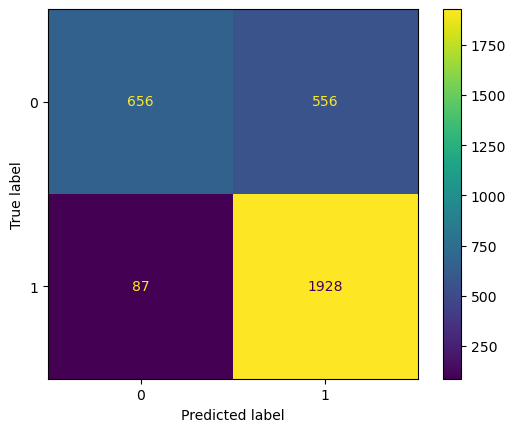

In [91]:
conf_matrix_plot(xgb_cv, X_test, y_test)

## Get feature Importances for Feature Selection

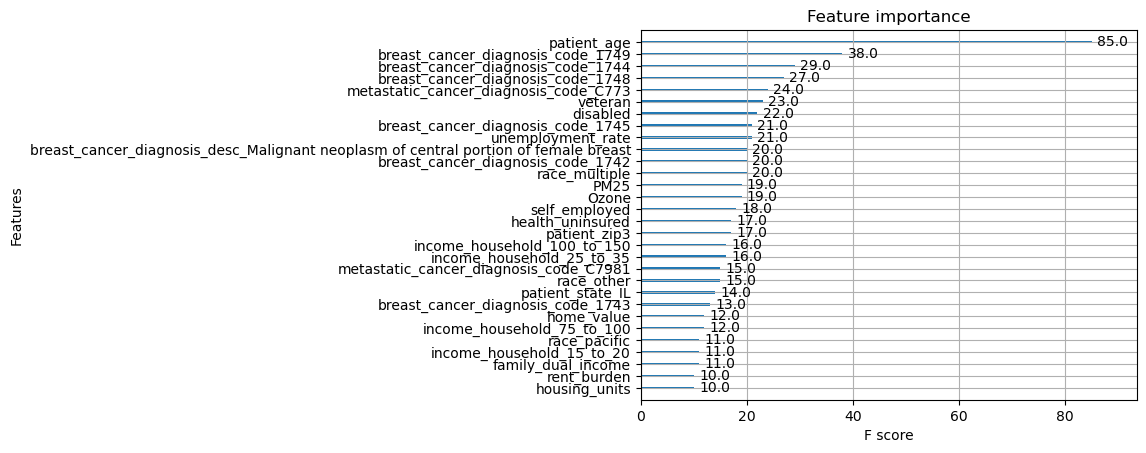

In [116]:
#plt.figure(figsize=(20,80))
plot_importance(xgb_cv.best_estimator_, max_num_features = 30);

In [117]:
# Make a new DataFrame that only has the most predictive variables selected
top20_features_subset = encoded_data[['DiagPeriodL90D','patient_age', 'breast_cancer_diagnosis_code_1749', 'breast_cancer_diagnosis_code_1744', 'breast_cancer_diagnosis_code_1748', 'metastatic_cancer_diagnosis_code_C773','veteran', 'disabled', 'breast_cancer_diagnosis_code_1745', 'unemployment_rate', 'breast_cancer_diagnosis_desc_Malignant neoplasm of central portion of female breast', 'breast_cancer_diagnosis_code_1742', 'race_multiple', 'PM25', 'Ozone', 'self_employed','health_uninsured', 'patient_zip3', 'income_household_100_to_150', 'income_household_25_to_35', 'metastatic_cancer_diagnosis_code_C7981']]
top20_features_subset

,DiagPeriodL90D,patient_age,breast_cancer_diagnosis_code_1749,breast_cancer_diagnosis_code_1744,breast_cancer_diagnosis_code_1748,metastatic_cancer_diagnosis_code_C773,veteran,disabled,breast_cancer_diagnosis_code_1745,unemployment_rate,...,breast_cancer_diagnosis_code_1742,race_multiple,PM25,Ozone,self_employed,health_uninsured,patient_zip3,income_household_100_to_150,income_household_25_to_35,metastatic_cancer_diagnosis_code_C7981
0,1,84,0,0,0,0,3.500000,12.871429,0,8.471429,...,0,8.757143,8.650555,52.237210,13.428571,11.200000,924,11.571429,10.142857,0
1,1,62,0,0,0,1,4.103030,8.957576,0,5.103030,...,0,10.081818,8.487175,42.301121,15.224242,7.018182,928,19.760606,5.163636,0
2,1,43,0,0,0,1,7.446667,11.253333,0,4.560000,...,0,6.898333,7.642753,40.108207,13.722034,15.066667,760,20.875000,6.763333,0
3,0,45,0,0,0,1,4.809524,8.845238,0,5.264286,...,0,8.611905,7.229393,42.070075,18.502381,4.404762,926,18.850000,4.380952,0
4,0,55,1,0,0,1,13.106000,15.276000,0,4.258000,...,0,6.258000,4.110749,41.356058,13.029545,12.088000,836,13.620000,11.462000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,1,50,0,0,0,1,6.247059,17.400000,0,9.135294,...,0,6.005882,8.068682,38.753055,9.105882,6.300000,436,10.994118,10.364706,0
12902,1,50,0,0,0,1,5.671605,11.243210,0,5.332099,...,0,9.274074,6.265266,36.469947,14.116250,3.845679,945,18.003750,5.148750,0
12903,1,61,0,0,0,0,4.809524,8.845238,0,5.264286,...,0,8.611905,7.229393,42.070075,18.502381,4.404762,926,18.850000,4.380952,0
12904,0,37,1,0,0,1,1.755263,10.194737,0,7.184211,...,0,6.089474,7.879795,37.722740,18.145946,6.392105,112,14.889474,7.589474,0


### Correlations & Heat Map

<Axes: >

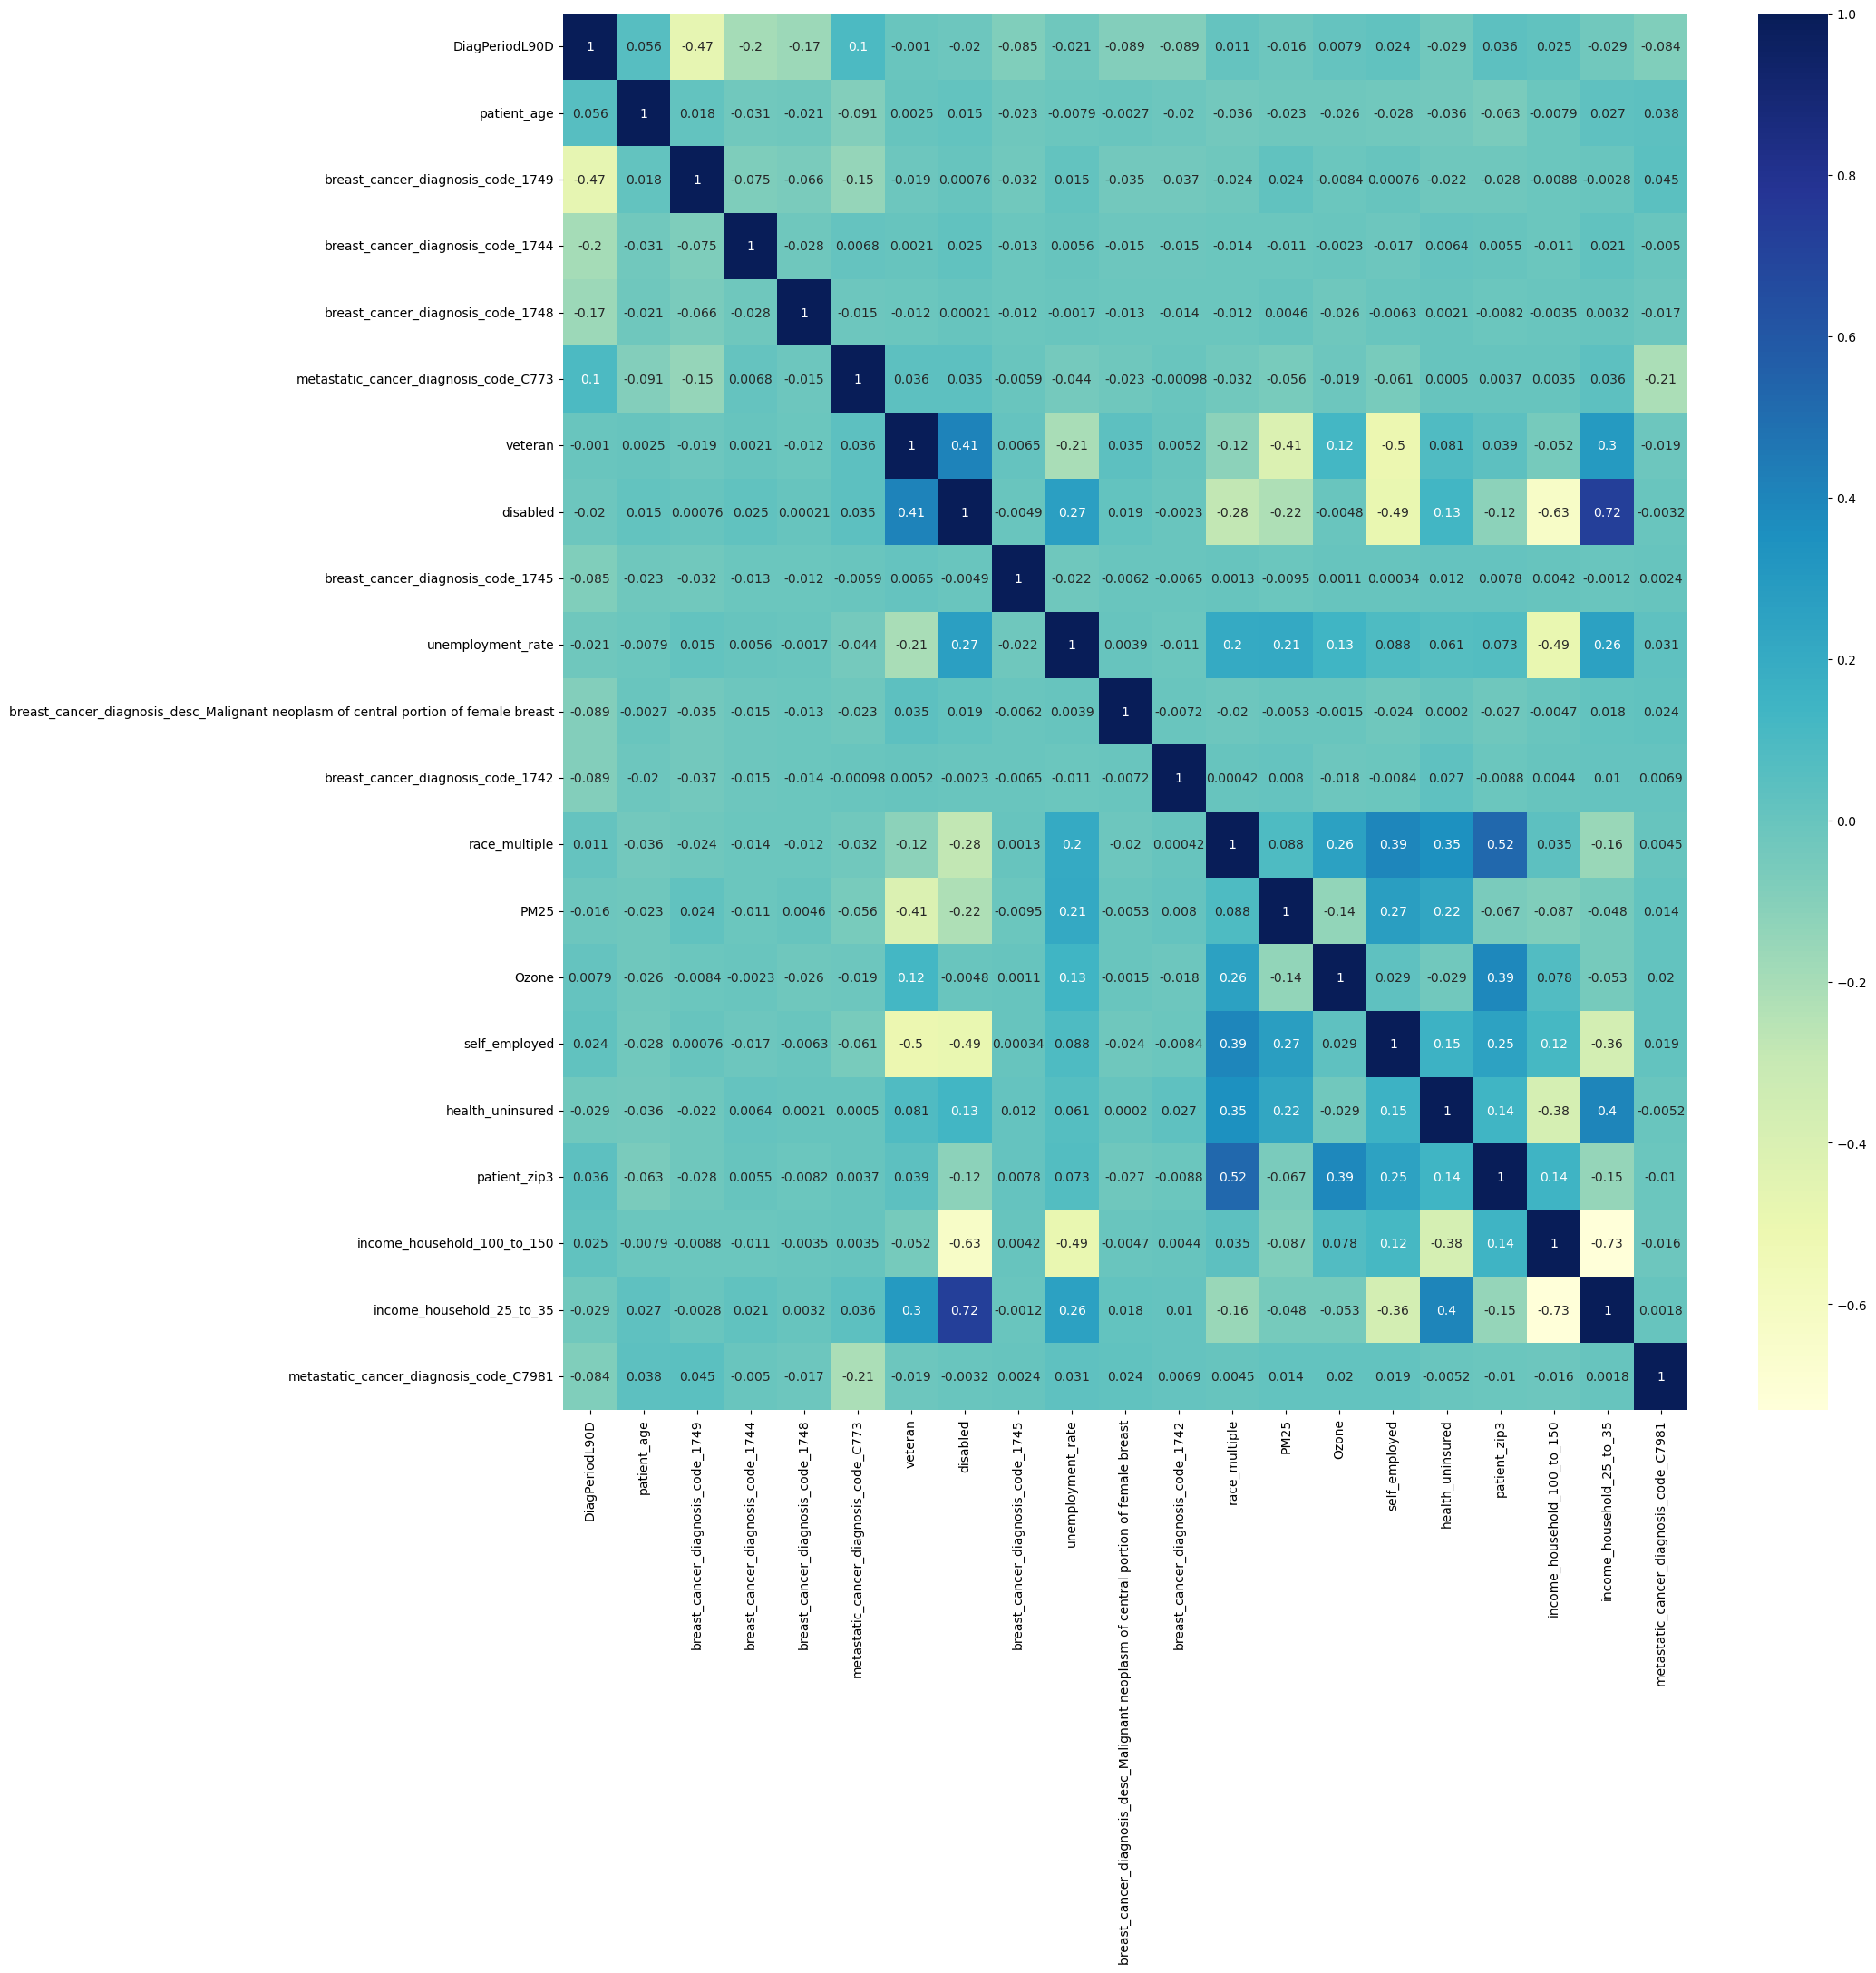

In [118]:
# Visualize the correlations between the most important features
corr = top20_features_subset.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, cmap='YlGnBu', annot=True, xticklabels=True, yticklabels=True)

# Results
### There is a lot to further unpack, but upon first glance, there is definitely a story of Equity in Healthcare to tell here. 

### It appears that in addition to medical indicators of a patient's cancer and health status, there are a number of potential social determinants of health outcomes; the demographic, environmental, and patient characteristic data is significant in a very strong predictive model of whether or not a patient will receive a potentially life saving 90 day diagnosis. Among the strongest correlations visualized above, we see that household income, disability status, veteran status, race, zipcode, and being uninsured are all factors at play here. These dynamics interconnect, as they are strongly related to eachother. These same variables have negative correlations with whether a patient is diagnosed within that crucial window of time.

### From a modeling standpoint, assumptions of independent variables may need to be tested. In addition, unearthing these relationships could help tell a story, so more EDA is called for.

# NEXT STEPS: Use Naive Bayes to get 90 Day Diagnosis Probabilities for each patient

In [ ]:
## Pre Process - EDA, Cleaning, Feature Transformation, Feature Extraction, etc

In [ ]:
## Fit the Model

In [ ]:
## Model Evaluation

In [ ]:
## Create Final DF with 2 columns - patient_id & predicted probability